This notebook provides the r code that can be used to reproduce the results reported in the article "Ventilator-induced signal interference and the accuracy of the pressure reactivity index in acute brain injury" by Charikleia S Vrettou and Michail Loulakis. In particular, it reproduces the figures generated by numerical experiments.

The r functions in the following cell take a vector $x$ as input, which is supposed to be a continuous signal sampled at rate `f_s`.
The functions average the signal over a window of size `window_size` and then downsample by `window_size`, as in the standard computation of the PRx (function avedown0), or by `step_size` as an alternative that reduces aliasing effects (function avedown). They will be used for the computation of the PRx index.

In [5]:
library(signal)

# Operator of averaging over 10 sec and downsampling by Ν=1000
avedown0 <- function(x, fs=100){
  # 0% overlap
  window_size <- 10 * fs
  num_windows <- 30
  # Reshape x into matrix with 30 columns (one per chunk)
  x_mat <- matrix(x[1:(num_windows * window_size)], nrow = window_size)
  # Compute 10 sec averages
  xav <- colMeans(x_mat)
  return(xav)
}

# Operator of averaging over 10 sec and downsampling by M=200
avedown <- function(x, fs=100){
  # 80% overlap
  window_size <- 10 * fs   # 10 seconds
  step_size <- 2 * fs      # 2 seconds
  num_windows <- 30
  # Moving average filter (FIR with equal weights)
  ma_filter <- rep(1 / window_size, window_size)
  # Filter the signal
  x_avg <- filter(ma_filter, 1, x)
  # downsample the signal
  x_down<-x_avg[seq(window_size, length(x_avg), by = step_size)]
  return(x_down)
}

**Figure 2** (The transfer function of the averaging filter)

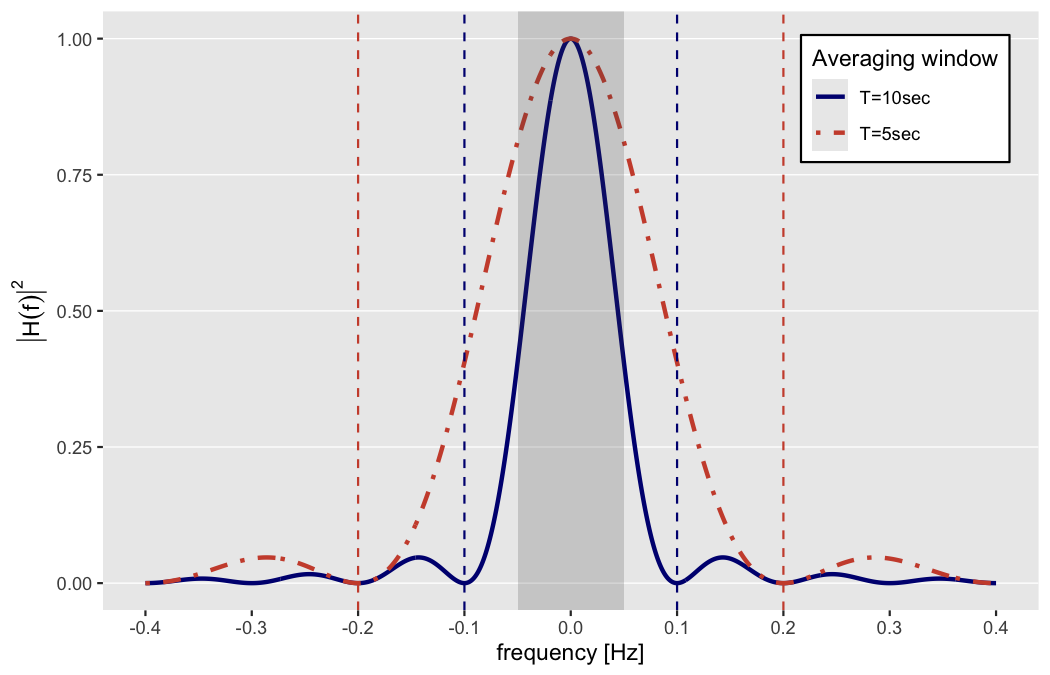

In [7]:
# r code for Figure 2 (transfer function)

options(
  repr.plot.width = 7,
  repr.plot.height = 4.5,
  repr.plot.res = 150
)

# Plots (simple) the transfer function of an averaging filter

library(ggplot2)
library(latex2exp)

fs<-100

transfer <- function(f, T = 10, fs = 100){
  x <- ifelse(
    f == 0,
    1,
    sin(pi * f * T) / (fs * T * sin(pi * f / fs))
  )
  return(x*x)
}

# Define frequency range
x<-seq(from=-0.4, to=0.4, by=0.001)

# Define transfer function values
df<-data.frame(
  x = rep(x,2),
  y = c(transfer(x),transfer(x,5)),
  Tattr = factor(rep(c("T=10sec","T=5sec"), each = length(x)))
)

p<-ggplot(df,aes(x=x, y=y, color = Tattr, linetype = Tattr))+
  geom_line(linewidth=1)+
  scale_x_continuous(breaks=seq(-0.5,0.5,0.1))+
  scale_y_continuous(breaks=seq(0,1,0.25))+
  scale_color_manual(values = c("T=10sec" = "navyblue", "T=5sec"="tomato3")) +
  scale_linetype_manual(values = c("T=10sec" = "solid", "T=5sec" = "dotdash"))+
  labs(x="frequency [Hz]", y=TeX("$|H(f)|^2$"), linetype="Averaging window", color="Averaging window")+
  theme(panel.grid.major.y = element_line(color = "white", linewidth = 0.3),
    panel.grid = element_blank(),
    legend.position = c(0.96, 0.95),
    legend.justification = c(0.96, 0.95),
    legend.background = element_rect(fill = "white", color = "black")
  )+
  geom_vline(
    xintercept = c(-0.1, 0.1),
    linetype = "dashed",
    color = "navyblue"
  )+
  geom_vline(
    xintercept = c(-0.2, 0.2),
    linetype = "dashed",
    color = "tomato3"
  )+
  annotate(
    "rect",
    xmin = -0.05, xmax = 0.05,
    ymin = -Inf, ymax = Inf,
    alpha = 0.2,
    fill = "gray30"
  )
print(p)

**Figure 4** (opposing long trends do not necessarily imply negative PRx)
The following code in r produces Figure 4 in the manuscript and computes the PRx between `signal1` and `signal2`. It requires the function avedown0, defined above. The user can modify the amplitude,`Atest`, and frequency, `ftest`, of the synchronous sinusoidal components of the signals.

The value of PRx between the two signals is 0.273883472077008



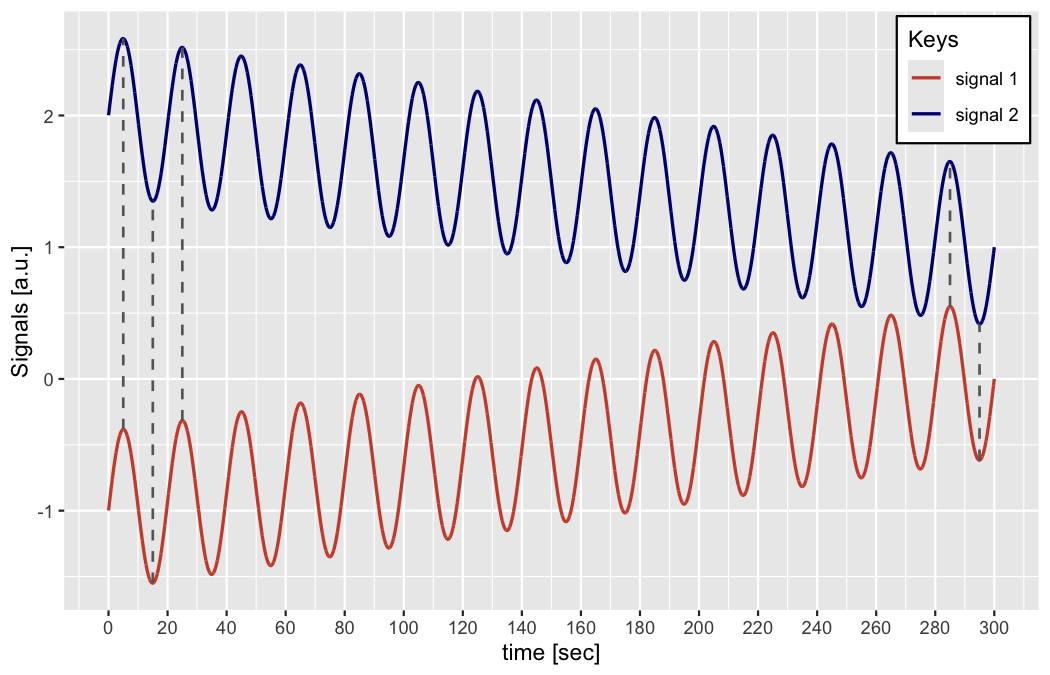

In [9]:
# r code for Figure 4 (opposing long trends do not necessarily imply negative PRx)
options(
  repr.plot.width = 7,
  repr.plot.height = 4.5,
  repr.plot.res = 150
)

library(ggplot2)

# Parameters
fs <- 100
time <- seq(from=1/fs, to=300, by=1/fs)

# Slow/fast trends and the two signals
u <- time/max(time) - 1

Atest <- 0.6
ftest <- 0.05
sin_val <- Atest * sin(2*pi*ftest*time)

signal1 <- u + sin_val
signal2 <- 1 - u + sin_val

df<-data.frame(
  tt = rep(time,2),
  signals = c(signal1,signal2),
  Tattr = factor(rep(c("signal 1", "signal 2"), each = length(time)))
)

# Define vertical segments that indicate synchronous fast signal
seg_times <- c(1/(4*ftest), 3/(4*ftest), 5/(4*ftest), 57/(4*ftest), 59/(4*ftest))
seg_y1 <- signal1[seg_times * fs]
seg_y2 <- signal2[seg_times * fs]
seg_df <- data.frame(
  x    = seg_times,
  y    = seg_y1,
  xend = seg_times,
  yend = seg_y2
)

# Common plot of signal1 and signal 2
p<-ggplot(df,aes(x=tt, y=signals, color = Tattr))+
  geom_line(linewidth=0.75)+
  scale_x_continuous(breaks=seq(0,300,20))+
  scale_color_manual(values = c("signal 1" = "tomato3", "signal 2" = "navyblue")) +
  labs(x="time [sec]", 
       y="Signals [a.u.]",
       color="Keys")+
  theme(
    legend.position = c(0.99, 0.99),
    legend.justification = c(0.99, 0.99),
    legend.background = element_rect(fill = "white", color = "black") 
  )+
  geom_segment(
    data = seg_df,
    aes(x = x, y = y, xend = xend, yend = yend),
    inherit.aes = FALSE,
    linewidth = 0.6,
    color = "gray40",
    linetype = "dashed"
  )

# Compute the PRx between signal 1 and signal 2
print(p)
prx <- cor(avedown0(signal1), avedown0(signal2), method = "pearson")
message("The value of PRx between the two signals is ",prx)


**Figure 5** (PRx as a function of the frequency/amplitute of the harmonic perturbation) 

In the following experiment we consider the functions 
$$u(t) = t/\tau, \quad 0\leq t \leq \tau,$$
and
$$h(t) =A\sin(2\pi f t), , \quad 0\leq t \leq \tau.$$
We use these to define the slow and fast trends of the signals
$$x(t)= 1 - u(t) + \alpha\cdot h(t)$$
and
$$y(t)=u(t) + h(t).$$
In the notation of the manuscript we have $\rho_s= -1$, because $x^s=1-y^s$, and $\rho_f=1$ because $x^f=y^f$. The parameter $A$ regulates $\chi=\psi=V(y^f)/V(y^s)$, while $\chi=\alpha^2\psi$. The default value of $A$ is chosen so that the (pre-filter) variances of the continuous time signals are equal.

First we vary the frequency of the fast, harmonic interference, from $f=\frac{1}{300}$ Hz to $f=0.4$ Hz and we compute the PRx between $x$ and $y$. We note that at large frequencies, the computed PRx is close to $\rho_s=-1$, i.e., a fast interference, $h$, does not affect the computed PRx much. On the other hand, low-frequency interferences may have a dramatic effect and the computed PRx may differ from $\rho_s$ profoundly.

We also note (red line) that downsampling introduces aliasing effects around odd multiples of the Nyquist frequency $f_n=\frac{f_s}{2N}$. When $f_s=100$ Hz and $N=1000$, aliasing manifests at $f=$ 0.05 Hz, 0.15 Hz, 0.25 Hz, ... To mitigate this effect, we recommend downsampling by $M=200$, i.e., keeping one value of the averaged signal every 2 seconds, rather than 10 seconds. This pushes the Nyquist frequency to $0.25$ Hz, where aliasing effects are already attenuated by averaging (blue line).

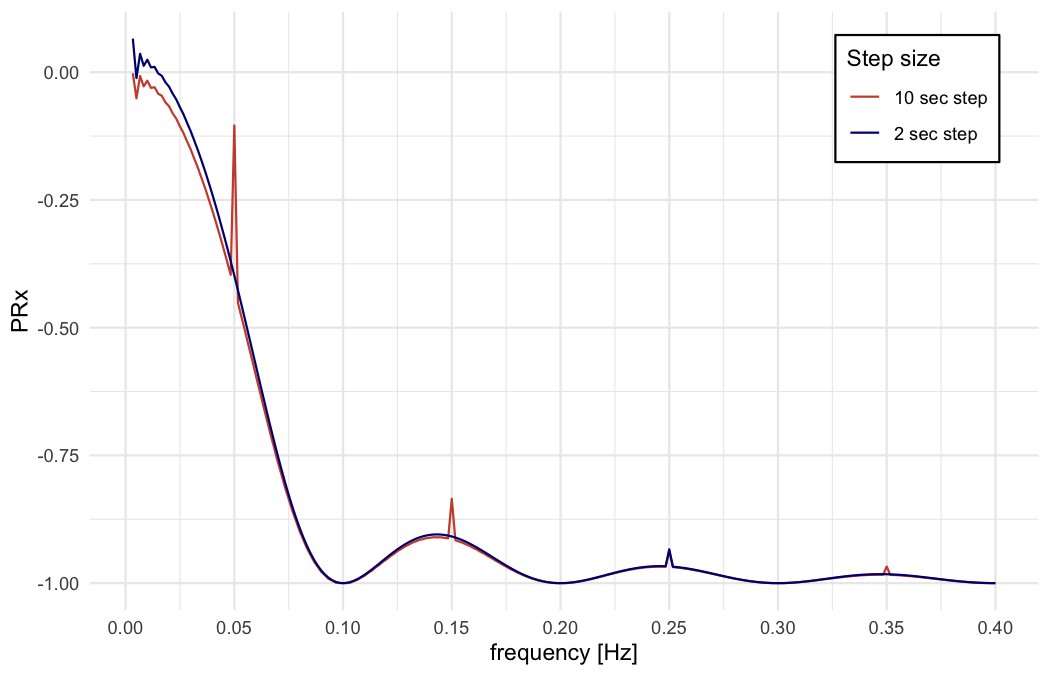

In [11]:
# r code for Figure 5,left (PRx as a function of the interference frequency)

library(ggplot2)

# Define the parameters
fs <- 100
time <- seq(from=1/fs, to=300, by=1/fs)
A <- 1/sqrt(6)
asym <- 1

# Define frequency range
frequency <- seq(1/300, 0.4, by = 1/600)
n_freq <- length(frequency)

# Define the slow signal
u <- time/max(time)

# Preallocate results vectors
prx0byf <- numeric(n_freq)
prxbyf <- numeric(n_freq)


# Compute PRx for each frequency
for (i in seq_along(frequency)) {
  h <- A * sin(2 * pi * frequency[i] * time)
  signal1 <- 1 - u + asym * h
  signal2 <- u + h  
  prx0byf[i] <- cor(avedown0(signal1), avedown0(signal2), method = "pearson")  
  prxbyf[i] <- cor(avedown(signal1), avedown(signal2), method = "pearson")
}


# Plot the result by frequency

df <- data.frame(
  frefre = rep(frequency, 2),
  prx = c(prx0byf, prxbyf),
  step = factor(rep(c("10 sec step", "2 sec step"), each = n_freq))
)

pf<-ggplot(df,aes(x=frefre, y=prx, colour = step))+
  geom_line(linewidth=0.5)+
  scale_x_continuous(breaks=seq(0,0.4,0.05))+
  scale_color_manual(values = c("10 sec step" = "tomato3", "2 sec step" = "navyblue")) +
  labs(x="frequency [Hz]", 
       y="PRx",
       color="Step size")+
  theme_minimal()+  
  theme(
    legend.position = c(0.95, 0.95),
    legend.justification = c(0.95, 0.95),
    legend.background = element_rect(fill = "white", color = "black") 
  )

print (pf)

Next, we vary the frequency of the fast, harmonic interference. We denote by $A_0$ the reference amplitude of the preceding experiment, we vary the amplitude of the harmonic signal from $A=0.03*A_0$ to $A=300*A_0$ and we compute the PRx between $x$ and $y$. To investigate potential aliasing effects, we do so for two distinct frequencies: $f=0.15$ Hz, a frequency that is an odd multiple of the Nyquist frequency so we expect aliasing effects, and $f=0.175$ Hz, where aliasing effects are not expected.

We note that at small amplituse interference, the computed PRx is close to $\rho_s=-1$, i.e., a low intensity interference, $h$, does not affect the computed PRx much. On the other hand, high-amplitude interferences may have a dramatic effect and the computed PRx may differ from $\rho_s$ profoundly.

We also note at $f=0.15$ Hz, aliasing shifts the curve to the left, i.e., for a given amplitude of the harmonic interference, the PRx we compute using 10 second steps (downsampling by $N=1000$) is larger than the PRx we compute using 2 second steps (downsampling by $M=200$). That is, at $f=0.15$ Hz, the PRx with 2 second steps is closer to the correlation coefficient between the slow trends, $\rho_s=-1$. This effect is absent at $f=0.175$ Hz.

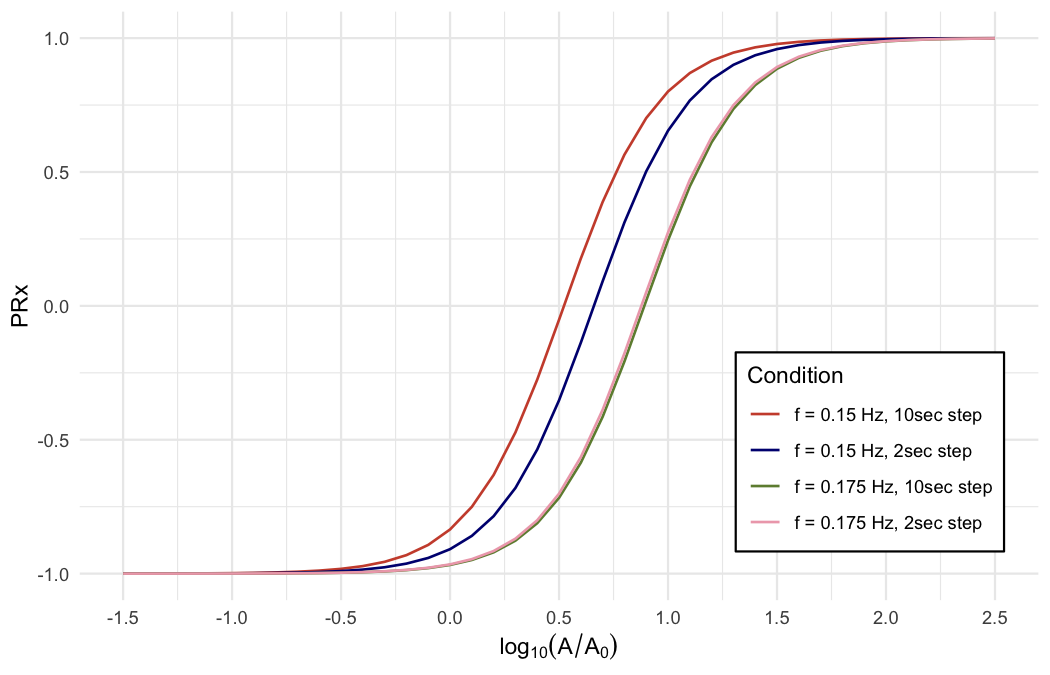

In [13]:
# r code for Figure 5, right (PRx as a function of the interference amplitude)

library(ggplot2)
library(latex2exp)

# Define Parameters
fs <- 100
time <- seq(0, 300, by = 1/fs)
u <- time / max(time)
logA <- seq(-1.5, 2.5, by = 0.1)
A_0 <- 1/sqrt(6)
asym <- 1


# Define normalized sinusoid
make_sin <- function(f, time) {
  s <- A_0 * sin(2 * pi * f * time) 
}

# PRx computation (both 10 sec and 2 sec steps)
compute_prx <- function(sin_sig, u, logA, fs) {
  A <- 10^logA
  out <- sapply(A, function(a) {
    c(
      cor(avedown0(u + a * sin_sig), avedown0(1 - u + asym * a * sin_sig), method = "pearson"),
      cor(avedown(u + a * sin_sig), avedown(1 - u + a * sin_sig), method = "pearson")
    )
  })
  t(out)
}

# Frequencies to test
freqs <- c(0.15, 0.175)

# Compute results
results <- lapply(freqs, function(f) {
  sin_sig <- make_sin(f, time)
  compute_prx(sin_sig, u, logA, fs)
})

# Assemble data frame
df <- data.frame(
  logA = rep(logA, times = 4),
  PRx  = c(results[[1]][,1], results[[1]][,2],
           results[[2]][,1], results[[2]][,2]),
  case = factor(
    rep(
      c("f = 0.15 Hz, 10sec step",
        "f = 0.15 Hz, 2sec step",
        "f = 0.175 Hz, 10sec step",
        "f = 0.175 Hz, 2sec step"),
      each = length(logA)
    )
  )
)

# Plot
pA <- ggplot(df, aes(x = logA, y = PRx, color = case)) +
  geom_line(linewidth = 0.6) +
  scale_x_continuous(breaks = seq(-1.5, 2.5, 0.5)) +
  scale_color_manual(
    values = c(
      "f = 0.15 Hz, 10sec step"     = "tomato3",
      "f = 0.15 Hz, 2sec step"  = "navyblue",
      "f = 0.175 Hz, 10sec step"    = "darkolivegreen4",
      "f = 0.175 Hz, 2sec step" = "pink2"
    )
  ) +
  labs(
    x = TeX("$\\log_{10}(A/A_0)$"),
    y = "PRx",
    color = "Condition"
  ) +
  theme_minimal() +
  theme(
    legend.position = c(0.95, 0.1),
    legend.justification = c(0.95, 0.05),
    legend.background = element_rect(fill = "white", color = "black")
  )

print(pA)

**Supplementary material**
We now consider the functions 
$$u(t) = t/\tau, \quad 0\leq t \leq \tau,$$
and
$$f(t) =A\cos(2\pi f t), , \quad 0\leq t \leq \tau.$$
We use these to define the slow and fast trends of the signals
$$x(t)= 1 - u(t) + \alpha\cdot f(t)$$
and
$$y(t)=u(t) + f(t).$$
In the notation of the manuscript we have $ \rho_s= -1$, because $x^s=1-y^s$, and $\rho_f=1$ because $x^f=\alpha y^f$. The paramater $A$ regulates $\psi=V(y^f)/V(y^s)$, while $\chi=\alpha^2\psi$. 

The following code in r computes and plots the actual error in equation (2) of the manuscript
$$ \text{Actual error}:= \Big|\text{PRx}-\rho_s\frac{1}{\sqrt{(1+\chi)(1+\psi)}}-\rho_f\frac{\sqrt{\chi\psi}}{\sqrt{(1+\chi)(1+\psi)}}\Big|,$$ 
as well as the theoretical error bound in Proposition 1 of the supplement
$$ \text{Error bound}:= \frac{2\varepsilon}{1-\varepsilon}\min\{\sqrt{\chi}+\sqrt{\psi},1+\frac{\varepsilon}{2}\},$$ 
as the frequency of the fast signal ranges from $\frac{1}{300}$ to 0.4 Hz.

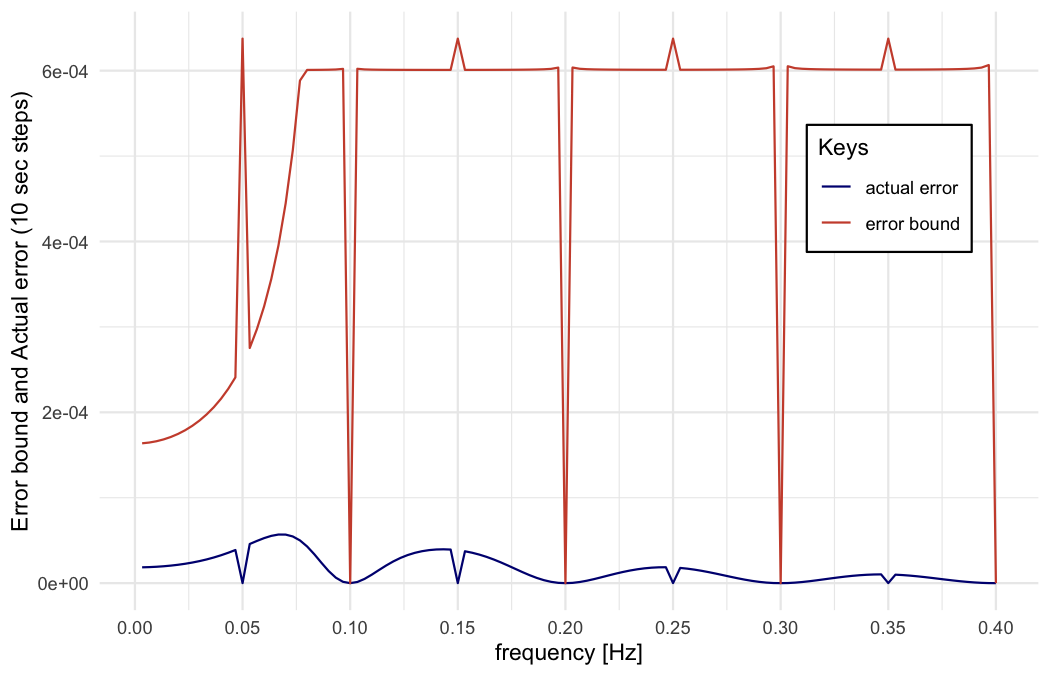

In [17]:
library(ggplot2)

# Define A, the amplitude of the sinusoidal, and alpha, the square root of the chi/psi ratio 
A <- 0.5
asym <- 2

fs<-100

# Define sampling time points
time <- seq(from=1/fs, to=300, by=1/fs)

# Predefine frequency range
frequency <- seq(1/300, 0.4, by = 1/300)
n_freq <- length(frequency)

# Preallocate results vectors
prxbyf <- numeric(n_freq)
rhsbyf <- numeric(n_freq)
errbyf <- numeric(n_freq)
theobyf <- numeric(n_freq) 

# Define the slow signal
u <- time/max(time)

# Define filtered slow signal
slow <- avedown0(u)
varslow <- var(slow)

# Compute PRx, rhs of eq (2), and the theoretical error bound of Proposition 1 for each frequency
for (i in seq_along(frequency)) {
  sin_f <- A * cos(2 * pi * outer(frequency[i], time))
  fast <- avedown0(sin_f)
  prxbyf[i] <- cor(1 - slow + asym * fast, slow + fast, method = "pearson")
  psi <- var(fast)/varslow
  rhsbyf[i] <- (asym * psi-1)/sqrt((psi+1)*(asym^2 * psi+1))
  epsi <- 0
  if (psi > 10^{-20}) {epsi <- abs(cor(slow, fast, method = "pearson"))}
  theobyf[i] <- 2* epsi*min((asym+1)*sqrt(psi),1+epsi/2)/(1-epsi)
}

# Compute the actual error term
errbyf <- prxbyf - rhsbyf

# Plot the result by frequency 
df<-data.frame(
  frefre = rep(frequency,2),
  theoact = c(theobyf,abs(errbyf)),
  Tattr = factor(rep(c("error bound", "actual error"), each = length(frequency)))
)
pf<-ggplot(df,aes(x=frefre, y=theoact, color = Tattr))+
  geom_line(linewidth=0.5)+
  scale_x_continuous(breaks=seq(0,0.4,0.05))+
  scale_color_manual(values = c("error bound" = "tomato3", "actual error" = "navyblue")) +
  labs(x="frequency [Hz]", 
       y="Error bound and Actual error (10 sec steps)",
       color="Keys")+
    theme_minimal()+
    theme(
    legend.position = c(0.92, 0.8),
    legend.justification = c(0.95, 0.95),
    legend.background = element_rect(fill = "white", color = "black")  
  )
pf

The following code in r repeats the computations and plots, this time using the function `avedown` rather than `avedown0`, so that PRx is computed with a `window_size` = 10 sec duration averaging window but with a `step_size` = 2 sec step, to mitigate aliasing effects.

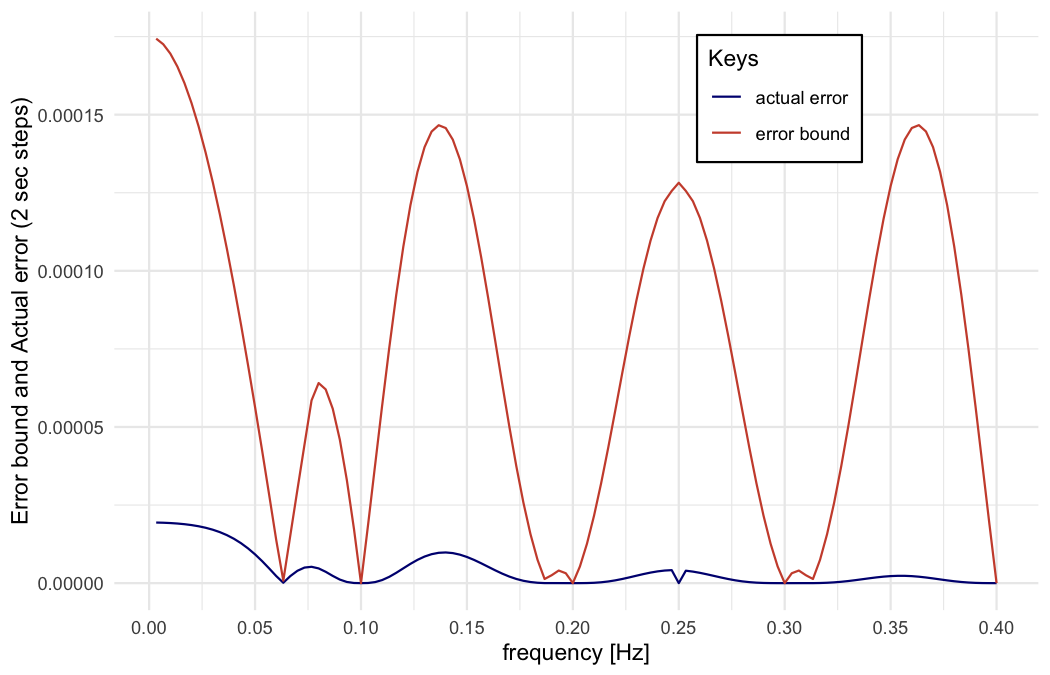

In [19]:
library(ggplot2)

# Define A, the amplitude of the sinusoidal, and alpha, the square root of the chi/psi ratio 
A <- 0.5
asym <- 2

fs<-100

# Define sampling time points
time <- seq(from=1/fs, to=300, by=1/fs)

# Predefine frequency range
frequency <- seq(1/300, 0.4, by = 1/300)
n_freq <- length(frequency)

# Preallocate results vectors
prxbyf <- numeric(n_freq)
rhsbyf <- numeric(n_freq)
errbyf <- numeric(n_freq)
theobyf <- numeric(n_freq) 

# Define the slow signal
u <- time/300

# Define filtered slow signal
 slow <- avedown(u)
 varslow <- var(slow)

# Compute PRx, rhs of eq (2), and the theoretical error bound of Proposition 1 for each frequency
for (i in seq_along(frequency)) {
  sin_f <- A * cos(2 * pi * outer(frequency[i], time))
  fast <- avedown(sin_f)
  prxbyf[i] <- cor(1 - slow + asym * fast, slow + fast, method = "pearson")
  psi <- var(fast)/varslow
  rhsbyf[i] <- (asym * psi-1)/sqrt((psi+1)*(asym^2 * psi+1))
  epsi <- 0
  if (psi > 10^{-20}) {epsi <- abs(cor(slow, fast, method = "pearson"))}
  theobyf[i] <- 2* epsi*min((asym+1)*sqrt(psi),1+epsi/2)/(1-epsi)
}

# Compute the actual error term
errbyf <- prxbyf - rhsbyf

# Plot the result by frequency 
df<-data.frame(
  frefre = rep(frequency,2),
  theoact = c(theobyf,abs(errbyf)),
  Tattr = factor(rep(c("error bound", "actual error"), each = length(frequency)))
)
pf<-ggplot(df,aes(x=frefre, y=theoact, color = Tattr))+
  geom_line(linewidth=0.5)+
  scale_x_continuous(breaks=seq(0,0.4,0.05))+
  scale_color_manual(values = c("error bound" = "tomato3", "actual error" = "navyblue")) +
  labs(x="frequency [Hz]", 
       y="Error bound and Actual error (2 sec steps)",
       color="Keys")+
    theme_minimal()+
    theme(
    legend.position = c(0.8, 0.95),
    legend.justification = c(0.95, 0.95),
    legend.background = element_rect(fill = "white", color = "black")
  )
pf